# Few-Shot Learning with Presto

### Demo Overview 

The purpose of the Demo is to show-case how to: 

- effectively train models on limited amount of annotated data
- show how multi-sensor and multi-temporal information can be integrated by mean of DL models

To this end, we will:

1) give a short introduction about Foundation Models and Presto
2) provide the definition of Few-Shot learning
3) apply Presto to perfrom Few-Shot learning on a regression and a classification task


### 1) Foundation Models

A Foundation Model is a pretrained model that is trained on large and diverse unlabelled datasets to learn general patterns and features. Due to its strong generalization capabilities, it can be adapted for a wide range of applications that use similar types of input data.

**Presto** (**P**retrained **Re**mote **S**ensing **T**ransf**o**rmer) is a foundation model trained on a large, unlabeled dataset of multi-sensor remote sensing data (Sentinel-2, Sentinel-1, Meteorological and Topography) pixel-timeseries. It is able to capture long-range relationships across time and sensor dimensions, improving the signal-to-noise ratio and providing a concise, informative representation of the inputs. 
We made use of the Presto version developed in collaboration with [WorldCereal](https://github.com/WorldCereal/presto-worldcereal/)

Originally trained on Montlhy composites, Presto has been refined to be able to ingest decadal data and to be fine-tuned for regression and classification tasks   

![General overview of the proposed pipeline for implementing few-shot learning using a Foundation Model pre-trained on multi-sensor data time-series.](/images/ScaleAG_FM_applications.svg)


### 2) Few-Shot Learning

Few-shot learning aims to develop models that can learn from a small number of labelled instances while enhancing generalization and performance on new, unseen examples.

Given a dataset with only a few annotated examples, we can fine-tune a pretrained foundation model and use it to create compressed versions of the inputs for performing supervised training on a ML model for a specific downstream task

### 3) Implementing Few-Shot learning with Presto

In [27]:
%load_ext autoreload
%autoreload 2
import catboost as cb
from catboost import Pool
import os
import openeo
from loguru import logger
import geopandas as gpd
import pandas as pd
from pathlib import Path
from torch.utils.data import DataLoader
from scaleagdata_vito.presto.datasets import ScaleAG10DDataset
from scaleagdata_vito.presto.presto_utils import (
    load_pretrained_model_from_url, 
    evaluate,
    evaluate_catboost,
    train_catboost_on_encodings,
)
from scaleagdata_vito.openeo.preprocessing import (
    run_openeo_extraction_job, 
    merge_datacubes
)
from scaleagdata_vito.demo.utils import (
    prepare_data_for_cb,
    prepare_cropland_data_for_presto,
    compare_performance_regression,
    compare_performance_classification,
)
from openeo_gfmap import (
    Backend,
    BackendContext,
    TemporalContext,
    FetchType,
)
from openeo_gfmap.manager.job_splitters import split_job_hex


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Fetch data from OpenEO

To set up the job, we adapt the job parameters to our needs. the compositing strategy is decadal by default

```python
job_params = dict(
    connection=openeo.connect("https://openeo.creo.vito.be/openeo/").authenticate_oidc(),
    backend_context=BackendContext(Backend.CDSE),
    temporal_extent=TemporalContext(
        start_date="yyyy-mm-dd", 
        end_date="yyyy-mm-dd",
    ),
    fetch_type=FetchType.POINT,
    disable_meteo=False,
    out_format="NetCDF", 
    title="...", # name of the job. can be monitored in the OpenEO Editor (https://editor.openeo.org/)
    split_dataset=False, # set to True for big and sparse datasets
    output_path="..." # where to save the extraction result. path to the parent folder when split_dataset=True 
)
```

In [13]:
# load dataframe with labels and polygons we want to extract openeo data for
gdf = (
    gpd.read_file(
        "/projects/TAP/HEScaleAgData/timeseries_modelling/datasets/" \
        "apr2024_AVR_subfields/data/AVR_fields_10000_100000_subfields_yield_bel_nl_roads_removed.geojson"
    ).drop(columns=["date"])
)

# setup OpenEO job parameters
job_params = dict(
    connection=openeo.connect("https://openeo.creo.vito.be/openeo/").authenticate_oidc(),
    backend_context=BackendContext(Backend.CDSE),
    temporal_extent=TemporalContext(
        start_date="2022-01-01",
        end_date="2022-12-31",
    ),
    fetch_type=FetchType.POINT,
    disable_meteo=False,
    out_format="NetCDF",
    title="ScaleAGData_demo",
    split_dataset=False,
    output_path="/home/vito/millig/gio/data/scaleag_demo/test"
)

output_path = Path(job_params["output_path"])
if not os.path.exists(job_params["output_path"]):
    output_path.mkdir(parents=True, exist_ok=True)

Authenticated using refresh token.


In [14]:
if job_params["split_dataset"]:
    datasets = split_job_hex(gdf)
    for i, sub_gdf in enumerate(datasets):
        logger.info(f"Extracting OpenEO data for subset {i}")
        output_path_frame = output_path / f"cube_{i}"
        output_path_frame.mkdir(parents=True, exist_ok=True)
        run_openeo_extraction_job(sub_gdf, str(output_path_frame), job_params)
    subset_files = list(output_path.glob("*/*.nc"))
    dataset = subset_files[0]
    for d in subset_files[1:]:
        dataset = merge_datacubes(dataset, d)
    dataset.to_netcdf(output_path / "demo_dataset_yield.nc")
else:
    logger.info(f"Extracting OpenEO data for dataset")
    run_openeo_extraction_job(gdf, str(output_path), job_params)

2024-09-13 10:56:23.637 | INFO     | __main__:<module>:14 - Extracting OpenEO data for dataset


Selected orbit direction: ASCENDING from max accumulated area overlap between bounds and products.


KeyboardInterrupt: 

#### Regression task: yield estimation 

In [2]:
# load preprocessed datasets
train_df = pd.read_parquet(
    "/home/vito/millig/projects/TAP/HEScaleAgData/data/AVR_subfields/" \
    "train_avr_subfields_10d_BE_NL_4-10_filtered.parquet"
)
val_df = pd.read_parquet(
    "/home/vito/millig/projects/TAP/HEScaleAgData/data/AVR_subfields/" \
    "val_avr_subfields_10d_BE_NL_4-10_filtered.parquet"
)
print(f"Number of Training samples: {len(train_df)}")
print(f"Number of Validation samples: {len(val_df)}")

Number of Training samples: 9121
Number of Validation samples: 1363


In [3]:
dl_train = DataLoader(
    ScaleAG10DDataset(
        train_df, target_name="median_yield", task="regression"
    ),
    batch_size=256,
    shuffle=True,
    num_workers=2,
)

dl_val = DataLoader(
    ScaleAG10DDataset(
        val_df, target_name="median_yield", task="regression"
    ),
    batch_size=256,
    shuffle=False,
    num_workers=2,
)

##### Train Catboost on Presto Encodings

In [4]:
presto_ss_10d_wc_ft_yield = "https://artifactory.vgt.vito.be/artifactory/auxdata-public/scaleagdata/models/presto-ss-wc_10D_NL-BE_4-10_ft.pt"
model_ft_10d_yield = load_pretrained_model_from_url(
    presto_ss_10d_wc_ft_yield, finetuned=True, ss_dekadal=True, strict=False, device="cpu"
)
presto_cbm = train_catboost_on_encodings(
    dl_train, 
    presto_model=model_ft_10d_yield, 
    task="regression", 
    cb_device="GPU"
    )

2024-09-13 11:59:06.862 | INFO     | scaleagdata_vito.presto.presto_utils:load_pretrained_model_from_url:94 -  Initialize Presto dekadal architecture with dekadal PrestoFT...
2024-09-13 11:59:07.123 | INFO     | scaleagdata_vito.presto.presto_utils:train_catboost_on_encodings:342 - Computing Presto encodings
2024-09-13 12:00:26.228 | INFO     | scaleagdata_vito.presto.presto_utils:train_catboost_on_encodings:344 - Fitting Catboost model on Presto encodings
TBB Warning: The number of workers is currently limited to 1. The request for 95 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



##### Train Catboost on raw data

In [5]:
train_cx, train_cy = prepare_data_for_cb(
    train_df, 
    target_name="median_yield",     
    lower_bound=dl_train.dataset.LOWER_BOUND, 
    upper_bound=dl_train.dataset.UPPER_BOUND, 
    )

val_cx, val_cy = prepare_data_for_cb(
    val_df, 
    target_name="median_yield",     
    lower_bound=dl_val.dataset.LOWER_BOUND, 
    upper_bound=dl_val.dataset.UPPER_BOUND, 
    )

In [6]:
raw_cbm = cb.CatBoostRegressor(
    random_state=3, 
    logging_level="Silent",
    task_type="GPU",
    loss_function="RMSE",
    )
train_pool = Pool(train_cx, train_cy)
raw_cbm.fit(train_pool);

##### Evaluate and Compare Performance

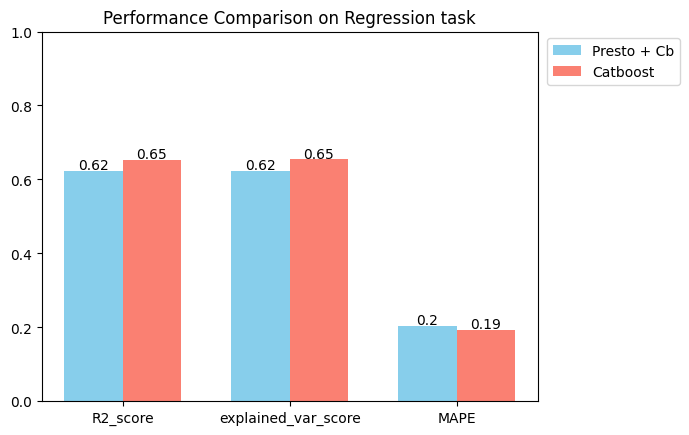

In [28]:
metrics_presto_cb, _, _ = evaluate(
    model_ft_10d_yield,
    presto_cbm,
    dl_val,
    task="regression",
    up_val=dl_val.dataset.UPPER_BOUND,
    low_val=dl_val.dataset.LOWER_BOUND,
)
metrics_raw_cb, _, _ = evaluate_catboost(
    raw_cbm,
    val_cx,
    val_cy,
    task="regression",
    up_val=dl_val.dataset.UPPER_BOUND,
    low_val=dl_val.dataset.LOWER_BOUND,
)
compare_performance_regression(metrics_presto_cb, metrics_raw_cb)

#### Classification task: Crop/No-Crop

In [8]:
wc_train_dataset = pd.read_parquet(
    "/home/vito/millig/gio/data/presto_ft/rawts-10d_train.parquet"
)

wc_val_dataset = pd.read_parquet(
    "/home/vito/millig/gio/data/presto_ft/rawts-10d_val.parquet"
)

wc_train_dataset = prepare_cropland_data_for_presto(wc_train_dataset, sample_frac=0.02)
wc_val_dataset = prepare_cropland_data_for_presto(wc_val_dataset, sample_frac=0.01)

print(f"Number of Training samples: {len(wc_train_dataset)}")
print(f"Number of Validation samples: {len(wc_val_dataset)}")

Number of Training samples: 9113
Number of Validation samples: 1139


In [9]:
wc_dl_train = DataLoader(
    ScaleAG10DDataset(
        wc_train_dataset, 
        target_name="LANDCOVER_LABEL",
        task="binary",
    ),
    batch_size=256,
    shuffle=True,
    num_workers=2,
)
wc_dl_val = DataLoader(
    ScaleAG10DDataset(
        wc_val_dataset,
        target_name="LANDCOVER_LABEL",
        task="binary",
    ),
    batch_size=256,
    shuffle=False,
    num_workers=2,
)

##### Train Catboost on Presto Encodings

In [10]:
presto_10d_ft_cropland = "https://artifactory.vgt.vito.be/artifactory/auxdata-public/scaleagdata/models/presto-ft-cl_10D_cropland.pt"
model_ft_10d_cropland = load_pretrained_model_from_url(
    presto_10d_ft_cropland, finetuned=True, strict=False, device="cpu"
    )

wc_presto_cbm = train_catboost_on_encodings(
    wc_dl_train,
    presto_model=model_ft_10d_cropland,
    task="binary",
    cb_device="GPU",
)

2024-09-13 12:01:45.238 | INFO     | scaleagdata_vito.presto.presto_utils:load_pretrained_model_from_url:94 -  Initialize Presto dekadal architecture with dekadal PrestoFT...
2024-09-13 12:01:45.481 | INFO     | scaleagdata_vito.presto.presto_utils:train_catboost_on_encodings:342 - Computing Presto encodings
2024-09-13 12:04:22.182 | INFO     | scaleagdata_vito.presto.presto_utils:train_catboost_on_encodings:344 - Fitting Catboost model on Presto encodings


##### Train Catboost on raw data

In [11]:
wc_train_cx, wc_train_cy = prepare_data_for_cb(
    wc_train_dataset, 
    target_name="LANDCOVER_LABEL",     
    )

wc_val_cx, wc_val_cy = prepare_data_for_cb(
    wc_val_dataset, 
    target_name="LANDCOVER_LABEL",     
    )

In [12]:
wc_raw_cbm = cb.CatBoostClassifier(
    random_state=3,
    task_type="GPU",
    logging_level="Silent",
)
wc_train_dataset = cb.Pool(wc_train_cx, wc_train_cy)
wc_raw_cbm.fit(wc_train_dataset);

##### Evaluate and Compare Performance

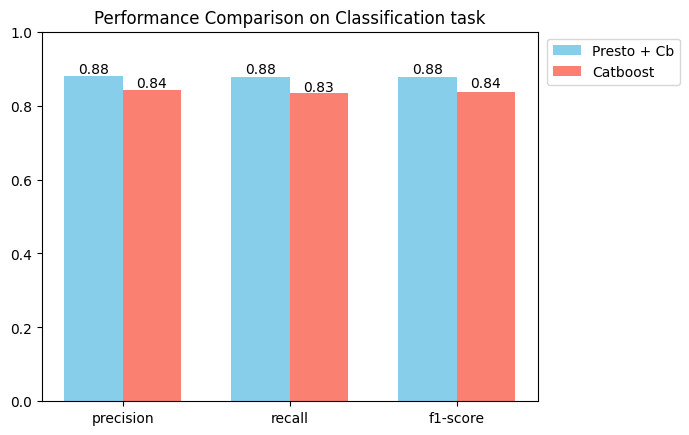

In [26]:
wc_metrics_presto_cb, _, _ = evaluate(
    model_ft_10d_cropland,
    wc_presto_cbm,
    wc_dl_val,
    task="binary",
)
wc_metrics_raw_cb, _, _= evaluate_catboost(
    wc_raw_cbm, 
    wc_val_cx,
    wc_val_cy,
    task="binary"
)
compare_performance_classification(wc_metrics_presto_cb, wc_metrics_raw_cb)